# Vision Transformers (ViT) On FER-2013


In [1]:
!pip install datasets torch
from datasets import load_dataset

/Users/alexker/anaconda3/envs/cs1430/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# images generated from stable diffusion https://huggingface.co/datasets/FER-Universe/DiffusionFER
# used to supplement training and increase robustness. 2581 training examples. no test images
# not used currently
diffusion_fer_dataset = load_dataset(
    'FER-Universe/DiffusionFER',     
    split='train'                           
)
diffusion_fer_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2581
    })
})

In [2]:
# just use the original fer-2013 dataset for now
# load directly from hf for the correct format
dataset_train = load_dataset(
    'Jeneral/fer-2013',
    split='train', # training dataset
)

dataset_train

Dataset({
    features: ['img_bytes', 'labels'],
    num_rows: 28709
})

In [3]:
dataset_test = load_dataset(
    'Jeneral/fer-2013',
    split='test', # testing dataset
    ignore_verifications=False  # set to True if seeing splits Error
)

dataset_test

/Users/alexker/anaconda3/envs/cs1430/lib/python3.9/site-packages/datasets/load.py:2555: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


Dataset({
    features: ['img_bytes', 'labels'],
    num_rows: 7178
})

In [4]:
from PIL import Image
import io

# Convert img_bytes to img in PIL format for both training and testing datasets
def convert_to_pil(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    # Convert back to RGB by duplicating the grayscale channel, required for vit
    image_RGB = Image.merge("RGB", (image, image, image))
    return image_RGB

dataset_train = dataset_train.map(lambda example: {'img': convert_to_pil(example['img_bytes'])}, remove_columns=['img_bytes'])
dataset_test = dataset_test.map(lambda example: {'img': convert_to_pil(example['img_bytes'])}, remove_columns=['img_bytes'])

# rename labels to label
dataset_train = dataset_train.rename_column("labels", "label")
dataset_test = dataset_test.rename_column("labels", "label")

In [5]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels


(7,
 ClassLabel(names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None))

In [6]:
dataset_train[0]

{'label': 0,
 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48>}

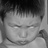

In [7]:
dataset_train[0]['img']


In [8]:
dataset_train[0]['label'], labels.names[dataset_train[0]['label']]

(0, 'angry')

### Loading ViT Feature Extractor

We use `google/vit-base-patch16-224-in21k` model from the Hugging Face Hub.

The model is named as so as it refers to base-sized architecture with patch resolution of 16x16 and fine-tuning resolution of 224x224.  

In [29]:
from transformers import ViTFeatureExtractor

# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)

: 

You can see the feature extractor configuration by printing it

In [10]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [11]:
example = feature_extractor(
    dataset_train[0]['img'],
    return_tensors='pt'
)
example

{'pixel_values': tensor([[[[-0.6078, -0.6078, -0.6157,  ..., -0.3098, -0.3255, -0.3255],
          [-0.6078, -0.6078, -0.6157,  ..., -0.3098, -0.3255, -0.3255],
          [-0.6078, -0.6078, -0.6157,  ..., -0.3098, -0.3255, -0.3255],
          ...,
          [-0.1843, -0.1843, -0.1843,  ..., -0.3333, -0.3490, -0.3490],
          [-0.1843, -0.1843, -0.1843,  ..., -0.3333, -0.3490, -0.3490],
          [-0.1843, -0.1843, -0.1843,  ..., -0.3333, -0.3490, -0.3490]],

         [[-0.6078, -0.6078, -0.6157,  ..., -0.3098, -0.3255, -0.3255],
          [-0.6078, -0.6078, -0.6157,  ..., -0.3098, -0.3255, -0.3255],
          [-0.6078, -0.6078, -0.6157,  ..., -0.3098, -0.3255, -0.3255],
          ...,
          [-0.1843, -0.1843, -0.1843,  ..., -0.3333, -0.3490, -0.3490],
          [-0.1843, -0.1843, -0.1843,  ..., -0.3333, -0.3490, -0.3490],
          [-0.1843, -0.1843, -0.1843,  ..., -0.3333, -0.3490, -0.3490]],

         [[-0.6078, -0.6078, -0.6157,  ..., -0.3098, -0.3255, -0.3255],
          [-0

In [12]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [13]:
# load in relevant libraries, and alias where appropriate
import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['img'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

We can apply this to both the training and testing dataset.

In [15]:
# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices).

### Model Fine-Tuning

In this section, we are going to build the Trainer, which is a feature-complete training and eval loop for PyTorch, optimized for HuggingFace 🤗 Transformers.

We need to define all of the arguments that it will include:
* training and testing dataset
* feature extractor
* model
* collate function
* evaluation metric
* ... other training arguments.

The collate function is useful when dealing with lots of data. Batches are lists of dictionaries, so collate will help us create batch tensors.

In [16]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Let's now define the evaluation metric we are going to use to compare prediction with actual labels. We will use the *accuracy evaluation metric*.

Accuracy is defined as the proportion of correct predictions (True Positive ($TP$) and True Negative ($TN$)) among the total number of cases processed ($TP$, $TN$, False Positive ($FP$), and False Negative ($FN$)).

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$    

Below, we are using accuracy within the ```compute_metrics``` function.

In [17]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

<ipython-input-17-b7bbca42f0bd>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The last thing consists of defining ```TrainingArguments```.

Most of these are pretty self-explanatory, but one that is quite important here is ```remove_unused_columns=False```. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

We have chosen a batch size equal to 16, 100 evaluation steps, and a learning rate of $2e^{-4}$.

In [18]:
# need to downgrade
!pip install accelerate==0.2.1
!pip install transformers==4.17

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./fer_2013",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=1,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=1e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
  optim="adamw_hf",
  logging_dir='./logs',
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


We can now load the pre-trained model. We'll add ```num_labels``` on init so the model creates a classification head with the right number of units.

In [26]:
from transformers import ViTForImageClassification

labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels)
)

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attent

In [27]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768,

We can see the characteristics of our model.

Now, all instances can be passed to ```Trainer```.

In [35]:
from transformers import Trainer
import os

# Check if there are any checkpoints in the output directory
def get_latest_checkpoint():
  latest_checkpoint = None
  if os.path.exists(training_args.output_dir):
      # List all files in the output directory
      checkpoint_files = os.listdir(training_args.output_dir)
      # Filter for checkpoint directories
      checkpoints = [os.path.join(training_args.output_dir, f) for f in checkpoint_files if "checkpoint" in f]
      # Find the latest checkpoint if any
      if checkpoints:
          latest_checkpoint = max(checkpoints, key=os.path.getmtime)
          print(f"Will resume training from checkpoint: {latest_checkpoint}")
      else:
          print("No checkpoint found, will start training from scratch")
  return latest_checkpoint

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

In [ ]:
# start tensorboard before training starts
%load_ext tensorboard
%tensorboard --logdir=./logs

We can save our trained model.

In [30]:
trainer.train(resume_from_checkpoint=True)
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

Loading model from ./fer_2013/checkpoint-600).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28709
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1795
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 600
  Will skip the first 0 epochs then the first 600 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/600 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,Accuracy
700,0.955400,1.085799,0.589161
800,1.142600,1.110590,0.583589
900,0.951700,1.025185,0.616188
1000,1.038800,1.033975,0.620786


***** Running Evaluation *****
  Num examples = 7178
  Batch size = 8
Saving model checkpoint to ./fer_2013/checkpoint-700
Configuration saved in ./fer_2013/checkpoint-700/config.json
Model weights saved in ./fer_2013/checkpoint-700/pytorch_model.bin
Feature extractor saved in ./fer_2013/checkpoint-700/preprocessor_config.json
Deleting older checkpoint [fer_2013/checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 7178
  Batch size = 8
Saving model checkpoint to ./fer_2013/checkpoint-800
Configuration saved in ./fer_2013/checkpoint-800/config.json
Model weights saved in ./fer_2013/checkpoint-800/pytorch_model.bin
Feature extractor saved in ./fer_2013/checkpoint-800/preprocessor_config.json
Deleting older checkpoint [fer_2013/checkpoint-600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 7178
  Batch size = 8
Saving model checkpoint to ./fer_2013/checkpoint-900
Configuration saved in ./fer_2013/checkpoint-900/config.j

KeyboardInterrupt: 

#### Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [31]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 7178
  Batch size = 8


Step,Training Loss,Validation Loss,Accuracy
700,0.955400,1.085799,0.589161
800,1.142600,1.110590,0.583589
900,0.951700,1.025185,0.616188
1000,1.038800,1.033975,0.620786
1078,1.048600,1.029969,0.617442


***** eval metrics *****
  eval_accuracy = 0.6174
  eval_loss     =   1.03


Model accuracy is pretty good. Let's have a look to an example. We can pick the first image in our testing dataset and see if the predicted label is correct.

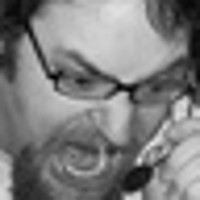

In [32]:
# show the first image of the testing dataset
image = dataset_test["img"][0].resize((200,200))
image

The image is not very clear, even when resized. Let's extract the actual label.

In [33]:
# extract the actual label of the first image of the testing dataset
actual_label = dataset_test["label"][0]

labels = dataset_test.features['label']
actual_label, labels.names[actual_label]


(0, 'angry')

In [4]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model from a local checkpoint
latest_checkpoint = get_latest_checkpoint()
model_finetuned = ViTForImageClassification.from_pretrained(latest_checkpoint)
# import features from the same checkpoint
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(latest_checkpoint)

NameError: name 'get_latest_checkpoint' is not defined

In [37]:
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits

We can now see what is our predicted label. Do extract it, we can use the argmax function.

In [38]:
predicted_label = logits.argmax(-1).item()
labels = dataset_test.features['label']
labels.names[predicted_label]

'angry'

In [41]:
# Assuming 'latest_checkpoint' contains the path to the latest checkpoint directory
if latest_checkpoint:
    checkpoint_dir_name = os.path.basename(latest_checkpoint)
    zip_file_name = f"{checkpoint_dir_name}.zip"
    # Create a zip file of the latest checkpoint directory
    !zip -r {zip_file_name} {latest_checkpoint}
    # Download manually by right-clicking on created zip file
else:
    print("No checkpoint available to download.")

  adding: fer_2013/checkpoint-1000/ (stored 0%)
  adding: fer_2013/checkpoint-1000/config.json (deflated 53%)
  adding: fer_2013/checkpoint-1000/rng_state.pth (deflated 25%)
  adding: fer_2013/checkpoint-1000/pytorch_model.bin (deflated 7%)
  adding: fer_2013/checkpoint-1000/preprocessor_config.json (deflated 46%)
  adding: fer_2013/checkpoint-1000/scheduler.pt (deflated 56%)
  adding: fer_2013/checkpoint-1000/optimizer.pt (deflated 8%)
  adding: fer_2013/checkpoint-1000/training_args.bin (deflated 51%)
  adding: fer_2013/checkpoint-1000/trainer_state.json (deflated 84%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [2]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

Predicted: LABEL_3



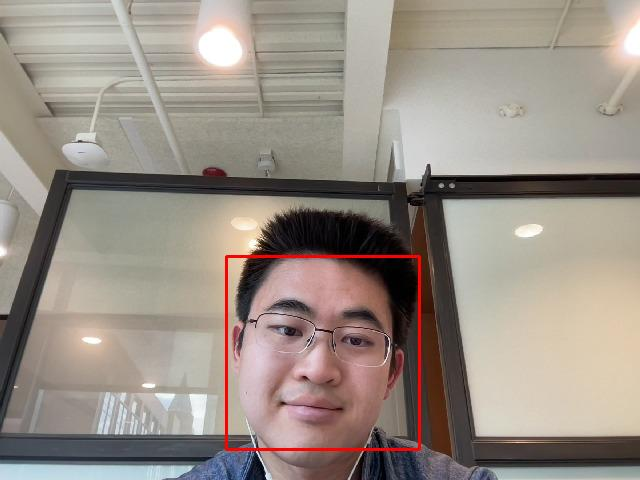

<IPython.core.display.Javascript object>

Predicted: LABEL_4



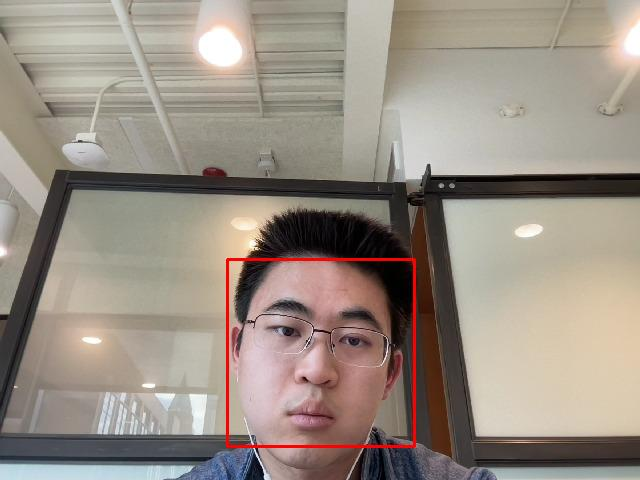

<IPython.core.display.Javascript object>

Predicted: LABEL_4



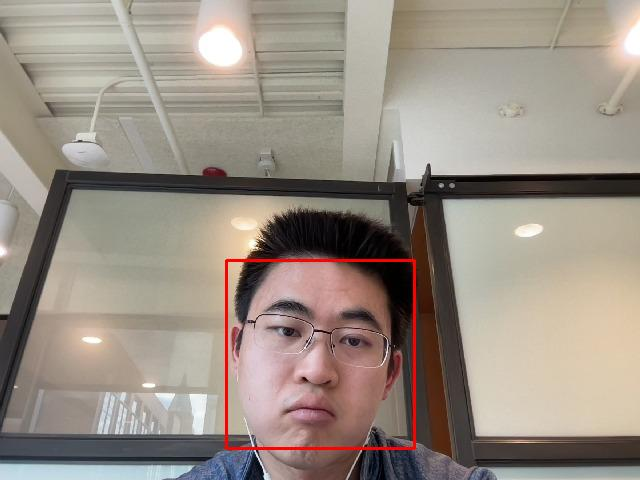

<IPython.core.display.Javascript object>

Predicted: LABEL_4



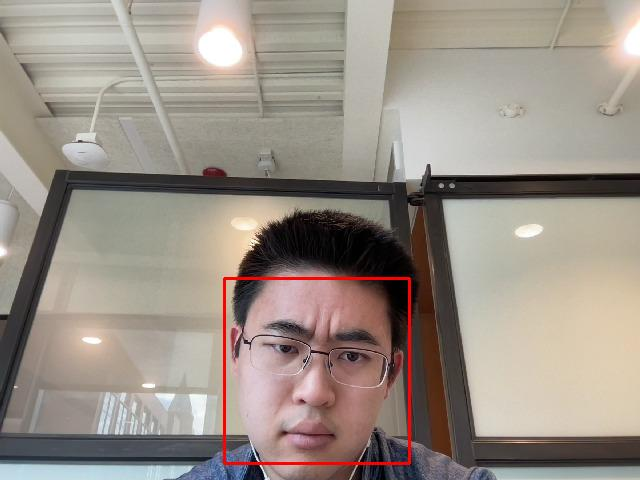

<IPython.core.display.Javascript object>

Predicted: LABEL_4



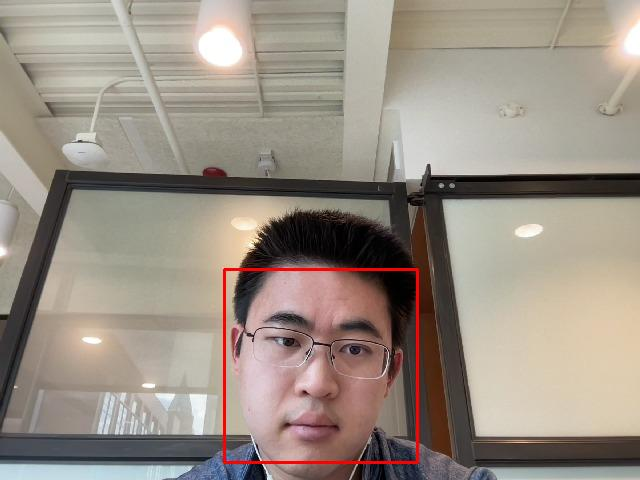

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [20]:
from IPython.display import display, Javascript
from base64 import b64decode
from PIL import Image
import numpy as np
import cv2
from io import BytesIO

def real_time_inference():
    js = Javascript('''
    async function captureFrame() {
        const div = document.createElement('div');
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Wait for the video to start playing
        await new Promise(resolve => setTimeout(resolve, 1000));

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        const dataUrl = canvas.toDataURL('image/jpeg');
        stream.getTracks().forEach(track => track.stop()); // Stop the video stream
        div.remove();
        return dataUrl;
    }
    ''')
    display(js)
    data_url = eval_js('captureFrame()')
    image_data = b64decode(data_url.split(',')[1])
    image = Image.open(BytesIO(image_data))
    frame = np.array(image)  # Convert PIL Image to numpy array for OpenCV processing

    # Load pre-trained Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Load the finetuned model and feature extractor
    model = ViTForImageClassification.from_pretrained('./fer_2013/checkpoint-1000')
    feature_extractor = ViTFeatureExtractor.from_pretrained('./fer_2013/checkpoint-1000')

    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Process each face found
    for (x, y, w, h) in faces:
        # Extract face ROI (Region of Interest)
        face_roi = frame[y:y+h, x:x+w]

        # Preprocess the face ROI as per your model requirements
        inputs = feature_extractor(images=face_roi, return_tensors="pt")

        # Make prediction
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()

        # Get the class label
        class_label = model.config.id2label[predicted_class_idx]

        # Display the prediction
        display_str = f'Predicted: {class_label}'
        print(display_str)

        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Convert numpy array back to PIL Image for displaying in Colab
    frame = Image.fromarray(frame)
    img_byte_arr = BytesIO()
    frame.save(img_byte_arr, format='JPEG')
    encoded_img = b64encode(img_byte_arr.getvalue())
    img_str = encoded_img.decode('utf-8')
    img_html = f'<img src="data:image/jpeg;base64,{img_str}" />'
    display(HTML(img_html))

# Call the real-time inference function
while True:
  real_time_inference()



def extract_eye_region(frame, face_coordinates):
    """
    Extracts the eye region from the given frame based on the face coordinates.
    
    Args:
    frame (numpy array): The image from which to extract the eye region.
    face_coordinates (tuple): A tuple (x, y, w, h) representing the bounding box of the face.
    
    Returns:
    numpy array: The cropped image of the eye region.
    """
    x, y, w, h = face_coordinates
    # Typically, the eyes are located in the upper part of the face.
    # We can approximate the region of the eyes as the top 1/3 of the face.
    eye_region_height = h // 3
    eye_region = frame[y:y + eye_region_height, x:x + w]
    return eye_region


## References

[Article](https://pinecone.io/learn/vision-transformers/)

[1] Dosovitskiy et al., [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), 2021, CV.

[2] Vaswani et al., [Attention Is All You Need](https://arxiv.org/abs/1706.03762), 2017.

[3] Saeed M., [A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/), 2022, Attention, Machine Learning Mastery.